#**Prepare environment**

## Install reqiured libraries

In [ ]:
!pip install yfinance scikit-optimize

## Call libraries and modules

In [ ]:
import yfinance as yf
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import sample
from datetime import timedelta
from itertools import cycle

from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt.plots import plot_objective, plot_convergence
from sklearn.ensemble import GradientBoostingRegressor

##Functions

In [ ]:
def evaluate_regression_performance(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    mape = np.mean(np.abs((y_true - y_pred) / y_true)[mask]) * 100

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"Rsq: {r2:.4f}")

#**Finances**

## Data preparation

In [ ]:
# Download stock data from Yahoo Finance
ticker = "GOOGL"
price_type = 'Close'
start_date = "2010-01-01"
end_date = "2023-11-01"
data = yf.download(ticker, start = start_date, end = end_date)

# Feature engineering: Creating additional temporal features
data['Date'] = data.index
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Define features and target variable
features = ['Year', 'Month', 'Day', 'DayOfWeek']
target = price_type

X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sort the X_test index
X_test_sorted = X_test.sort_index()

[*********************100%%**********************]  1 of 1 completed


## Data exploration

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,DayOfWeek
count,3481.000000,3481.000000,3481.000000,3481.000000,3481.000000,3.481000e+03,3481.000000,3481.000000,3481.000000,3481.000000
mean,53.142972,53.693957,52.595806,53.157316,53.157316,5.858105e+07,2016.421143,6.487791,15.731686,2.024418
std,38.327028,38.784073,37.889171,38.342308,38.342308,4.859254e+07,3.991032,3.402574,8.749604,1.398781
min,10.968719,11.068068,10.851602,10.912663,10.912663,9.312000e+06,2010.000000,1.000000,1.000000,0.000000
25%,21.839338,21.971972,21.700701,21.821571,21.821571,2.852800e+07,2013.000000,4.000000,8.000000,1.000000
50%,40.494499,40.698002,40.255501,40.494999,40.494999,3.995200e+07,2016.000000,6.000000,16.000000,2.000000
75%,72.000000,72.449997,71.113998,71.962502,71.962502,7.731061e+07,2020.000000,9.000000,23.000000,3.000000
max,151.250000,151.546494,148.899002,149.838501,149.838501,5.923990e+08,2023.000000,12.000000,31.000000,4.000000


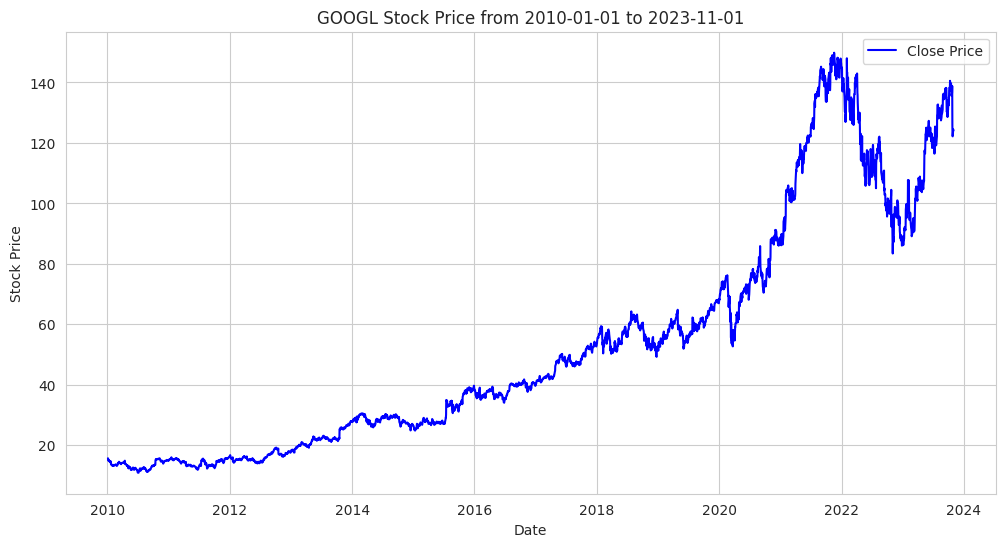

In [ ]:
# Visualize Stock Price
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[price_type], label= f'{price_type} Price', color='blue')
plt.title(f'{ticker} Stock Price from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<ipython-input-65-d1d5514542a2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[price_type], shade=True, color='blue')


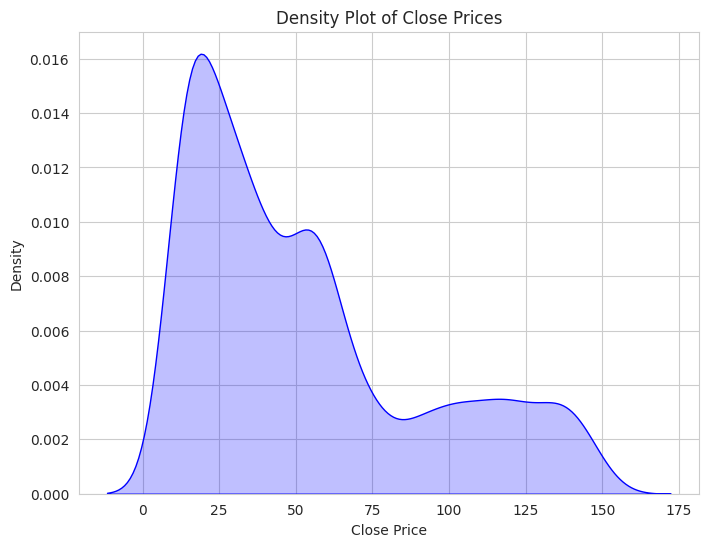

In [ ]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create the density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data[price_type], shade=True, color='blue')
plt.title(f'Density Plot of {price_type} Prices')
plt.xlabel(f'{price_type} Price')
plt.ylabel('Density')
plt.show()

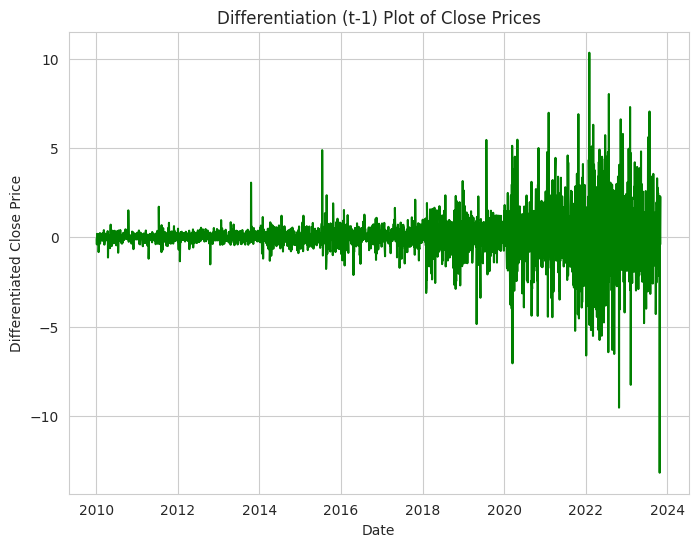

In [ ]:
# Calculate the differentiation (t-1) of the series
differentiated_series = data[price_type] - data[price_type].shift(1)

# Plot the differentiated series
plt.figure(figsize=(8, 6))
plt.plot(data.index, differentiated_series, color='green')
plt.title(f'Differentiation (t-1) Plot of {price_type} Prices')
plt.xlabel('Date')
plt.ylabel(f'Differentiated {price_type} Price')
plt.show()

## GRADIENT BOOSTING

### Gradient Boosting without optimization

In [ ]:
GB_base_model = GradientBoostingRegressor(criterion='squared_error', random_state=42)
GB_base_model.fit(X_train, y_train)

# Make predictions on the sorted test set
y_pred_sorted_gb_base = GB_base_model.predict(X_test_sorted)

# Performance metrics
evaluate_regression_performance(y_test[X_test_sorted.index], y_pred_sorted_gb_base)

MAE: 2.1120
MSE: 9.7089
RMSE: 3.1159
MAPE: 4.7472
Rsq: 0.9929


### Bayesian Optimization of Gradient Boosting

<Axes: >

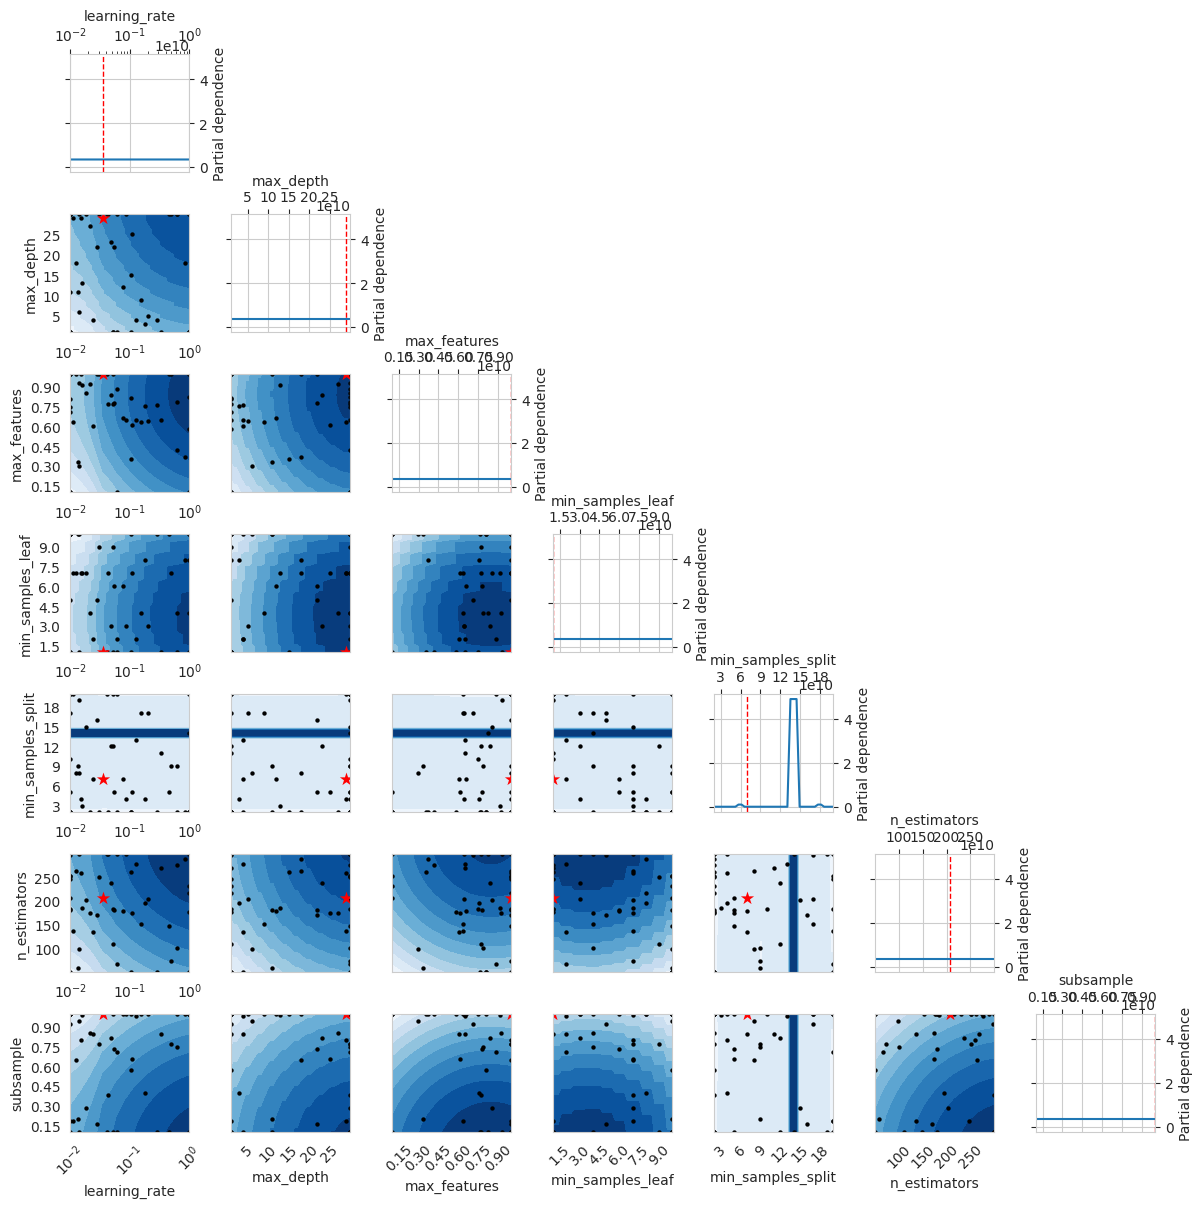

In [ ]:
param_space_gb =  {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (50, 300),
    'max_depth': (1, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'subsample': (0.1, 1.0, 'uniform'),
    'max_features': (0.1, 1.0, 'uniform')
}

# Initialize XGBoost Regressor
model_gb = GradientBoostingRegressor(criterion='squared_error', random_state=42)

# Initialize BayesSearchCV
opt = BayesSearchCV(model_gb, param_space_gb, n_iter=50, cv=5, n_jobs=-1)

# Fit the model
opt.fit(X_train, y_train)

# Get the best hyperparameters
best_params = opt.best_params_


# from skopt.plots import plot_objective, plot_convergence
plot_objective(opt.optimizer_results_[0], cmap='Blues')

In [ ]:
# Train the model with the best hyperparameters
best_model_gb = GradientBoostingRegressor(criterion='squared_error', **best_params)
best_model_gb.fit(X_train, y_train)

y_pred_sorted_best_gb_model = best_model_gb.predict(X_test_sorted)

# Performance metrics
evaluate_regression_performance(y_test[X_test_sorted.index], y_pred_sorted_best_gb_model)

MAE: 0.7714
MSE: 2.4318
RMSE: 1.5594
MAPE: 1.4780
Rsq: 0.9982


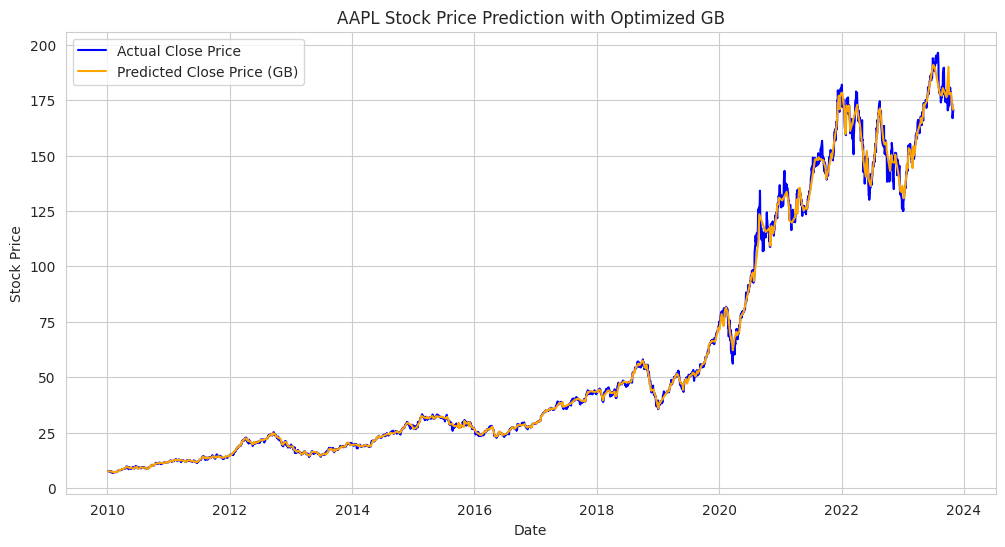

In [ ]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
plt.plot(X_test_sorted.index, y_pred_sorted_best_gb_model, label='Predicted Close Price (GB)', color='orange')
plt.title(f'{ticker} Stock Price Prediction with Optimized GB')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

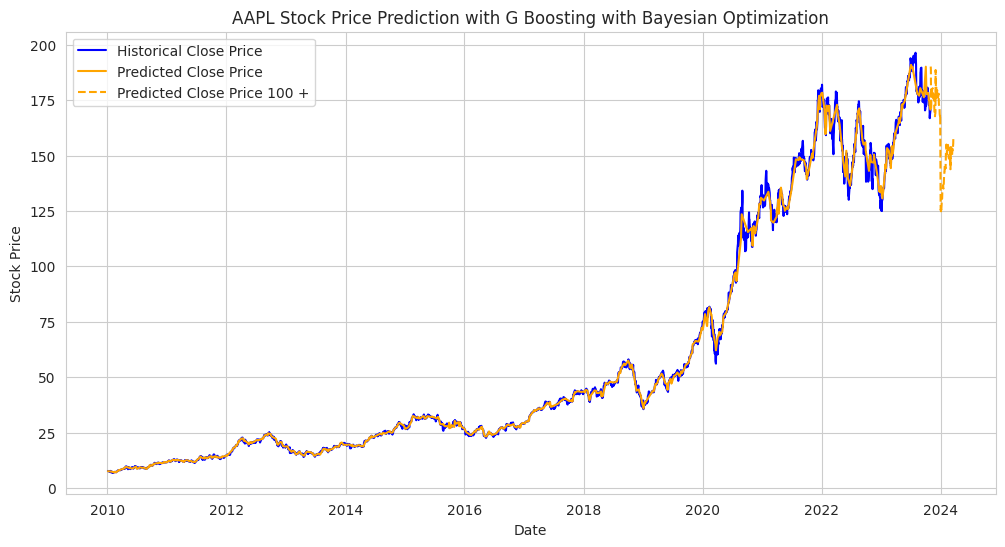

In [ ]:
# Generate future dates for prediction
future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=100, freq='B')  # Predicting for the next 30 business days

# Create a DataFrame with future dates and temporal features
future_features = pd.DataFrame({'Year': future_dates.year,
                                'Month': future_dates.month,
                                'Day': future_dates.day,
                                'DayOfWeek': future_dates.dayofweek})

# Make predictions for future dates using the trained XGBoost model
future_predictions_gb = best_model_gb.predict(future_features)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Price', color='blue')
plt.plot(X_test_sorted.index, y_pred_sorted_best_gb_model, label='Predicted Close Price', color='orange')
plt.plot(future_dates, future_predictions_gb, label='Predicted Close Price 100 +', color='orange', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction with G Boosting with Bayesian Optimization')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## **XTREME GRADIENT BOOSTING**



### XGB without optimization

In [ ]:
# Train the model with the best hyperparameters
base_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state = 42)
base_model_xgb.fit(X_train, y_train)

# Make predictions on the sorted test set
y_pred_sorted_base_xgb_model = base_model_xgb.predict(X_test_sorted)

# Performance metrics
evaluate_regression_performance(y_test[X_test_sorted.index], y_pred_sorted_base_xgb_model)

MAE: 0.9838
MSE: 3.0227
RMSE: 1.7386
MAPE: 2.1156
Rsq: 0.9989


### XGB with bayesian optimization

<Axes: >

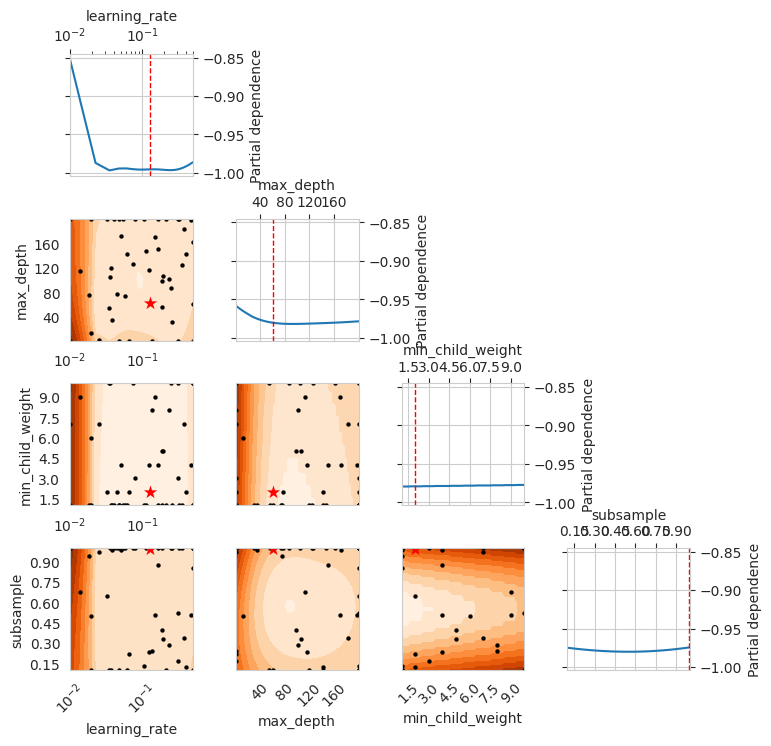

In [ ]:
# Define the search space
param_space_xgb = {
    'learning_rate': (0.01, 0.5, 'log-uniform'),
    'max_depth': (1, 200),
    'min_child_weight': (1, 10),
    'subsample': (0.1, 1.0, 'uniform')
}

# Initialize XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize BayesSearchCV
opt = BayesSearchCV(model_xgb, param_space_xgb, n_iter=50, cv=5, n_jobs=-1)

# Fit the model
opt.fit(X_train, y_train)

# Get the best hyperparameters
best_params = opt.best_params_


plot_objective(opt.optimizer_results_[0], cmap='Oranges')

In [ ]:
# Train the model with the best hyperparameters
best_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params, random_state = 42)
best_model_xgb.fit(X_train, y_train)

# Sort the X_test index
X_test_sorted = X_test.sort_index()

# Make predictions on the sorted test set
y_pred_sorted_xgb = best_model_xgb.predict(X_test_sorted)

# Performance metrics
evaluate_regression_performance(y_test[X_test_sorted.index], y_pred_sorted_xgb)

MAE: 0.8395
MSE: 2.4604
RMSE: 1.5686
MAPE: 1.5917
Rsq: 0.9991


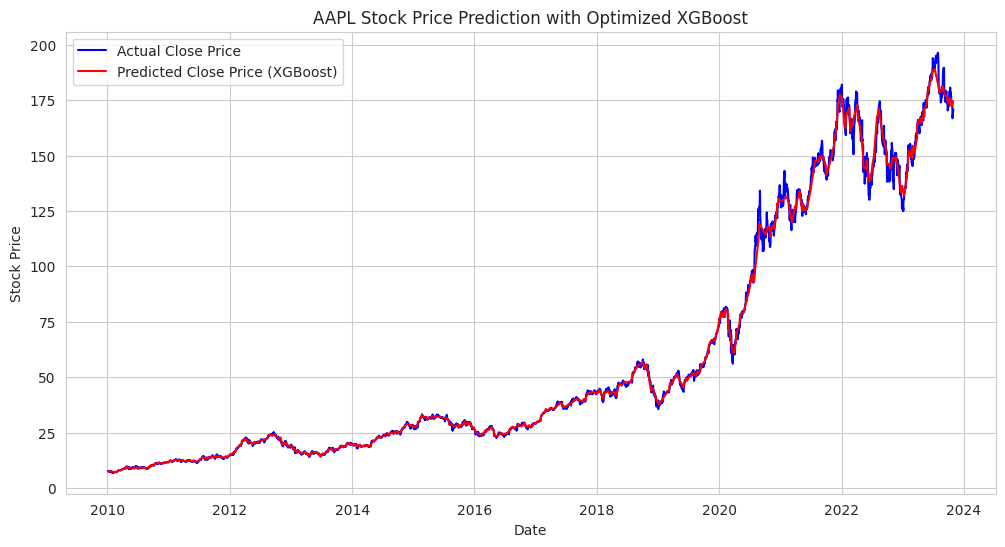

In [ ]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')
plt.plot(X_test_sorted.index, y_pred_sorted_xgb, label='Predicted Close Price (XGBoost)', color='red')
plt.title(f'{ticker} Stock Price Prediction with Optimized XGBoost')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

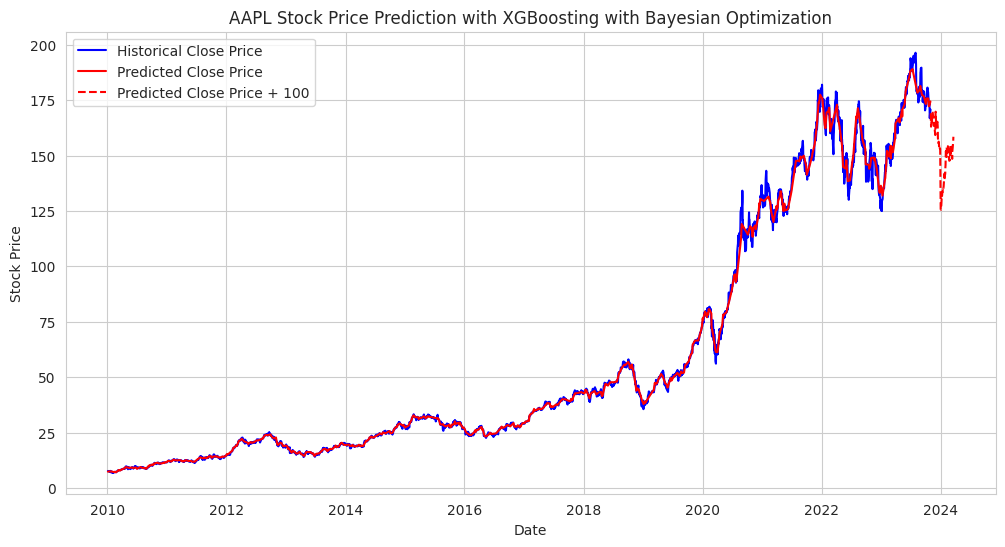

In [ ]:
# Generate future dates for prediction
future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=100, freq='B')  # Predicting for the next 30 business days

# Create a DataFrame with future dates and temporal features
future_features = pd.DataFrame({'Year': future_dates.year,
                                'Month': future_dates.month,
                                'Day': future_dates.day,
                                'DayOfWeek': future_dates.dayofweek})

# Make predictions for future dates using the trained XGBoost model
future_predictions_xgb = best_model_xgb.predict(future_features)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Historical Close Price', color='blue')
plt.plot(X_test_sorted.index, y_pred_sorted_xgb, label='Predicted Close Price', color='red')
plt.plot(future_dates, future_predictions_xgb, label='Predicted Close Price + 100', color='red', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction with XGBoosting with Bayesian Optimization')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

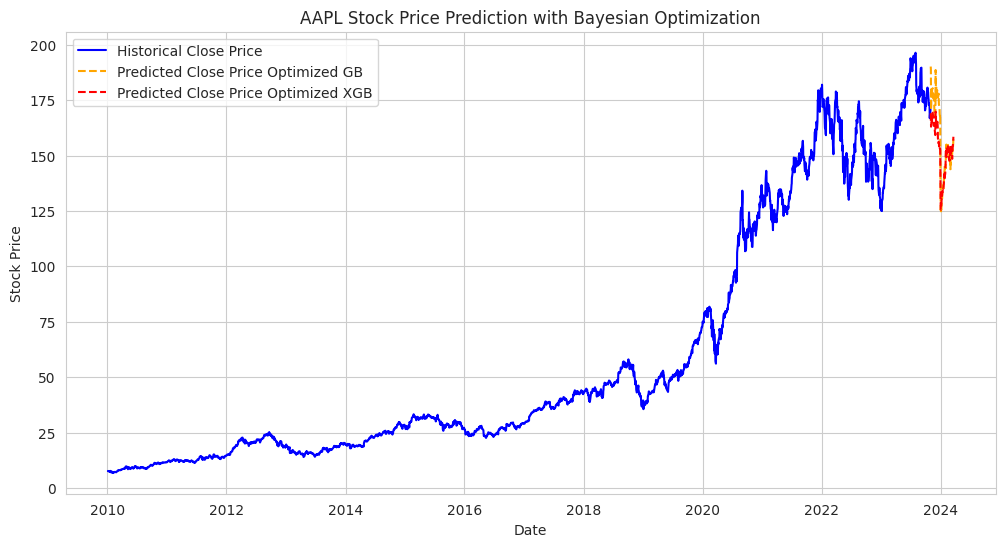

In [ ]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[price_type], label=f'Historical {price_type} Price', color='blue')
plt.plot(future_dates, future_predictions_gb, label=f'Predicted {price_type} Price Optimized GB', color='orange', linestyle='--')
plt.plot(future_dates, future_predictions_xgb, label=f'Predicted {price_type} Price Optimized XGB', color='red', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction with Bayesian Optimization')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()